# Waterfall individual predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
!pip3 install shap
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def generating_metrics(model_ehr, x, y):
    y_pred_proba = model_ehr.predict_proba(x)[:, 1]
    y_pred = model_ehr.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)
    return auc_score, sensitivity, specificity, f1, acc, false_positive_rate, true_positive_rate

def plot_roc(model,X_test, y_test):
    print("mean_cross_val_score: ", model.best_score_)
    print("best_params:",model.best_params_)
    print("=============================================================================")
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr_test, tpr_test = generating_metrics(model, X_test, y_test)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_test, sens_test, spec_test, f1_test, acc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_test, tpr_test, label='Testing (AUC=%0.2f)' % auc_test, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('ROC')
    plt.show()

def plot_shap_values(model,X,feature_list,title):
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X)
    plt.title(title)
    shap.summary_plot(shap_values, X, feature_names=feature_list, plot_type='bar',max_display=10)
    plt.title(title)
    shap.summary_plot(shap_values, X,feature_names=feature_list,show = 'False',max_display=10)

def plot_waterfall(model,X,id,name,logs_file):
    explainerModel_prob = shap.TreeExplainer(model.best_estimator_,
                                   data = shap.sample(X, 50),
                                   model_output='probability')
    

    shap_values_model_prob  = explainerModel_prob.shap_values(X)
    
    shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value,
                                           shap_values_model_prob[id,:],
                                           X.iloc[id,:],show=False,max_display=12)
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    plt.savefig(url_save,bbox_inches='tight')

In [3]:
raw_data = 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/data_morelos_rename.csv'
data = pd.read_csv(raw_data)
print ("Total de registros", data.shape[0])

Total de registros 12103


In [4]:
X = data.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality'],axis=1).astype(int)
y = data['Mortality'].astype(int) 
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X:: (12103, 39)
Y:: (12103, 1)


In [5]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Sex', 'LOCRESI',
       'Evolution', 'Intubated ', 'Age', 'Pregnancy', 'FECINGRE', 'FECINISI',
       'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'VIH-SIDA',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'RECTRATA',
       'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'Puerperium', 'Use of antipyretics',
       'ICU', 'CLASCOVID19', 'Days elapsed', 'HIV AIDS', 'Mortality'],
      dtype='object')

In [6]:
import joblib
XGB_loaded = joblib.load('C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/pkl/modelXGB1.pkl')

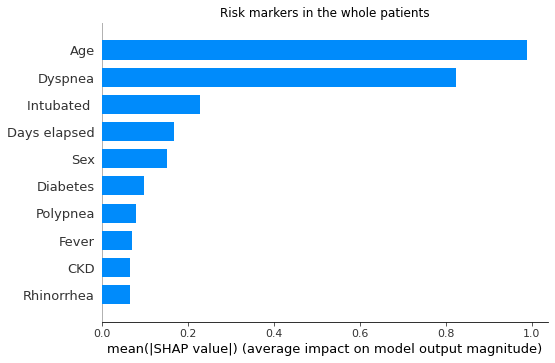

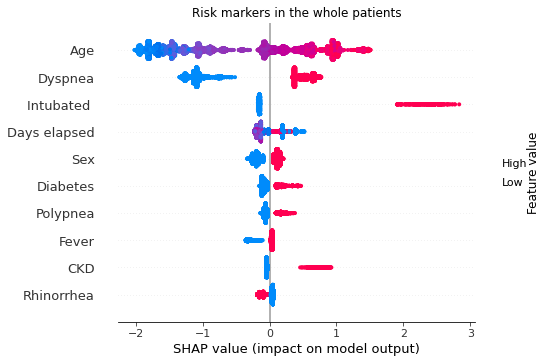

In [7]:
title = "Risk markers in the whole patients"
plot_shap_values(XGB_loaded,X,feature_list,title)

In [8]:
ids_patients_expired = np.where(data.Mortality==1)
print("Patients expired (ids):",ids_patients_expired)

Patients expired (ids): (array([    2,     6,    17, ..., 12004, 12060, 12068], dtype=int64),)


# Analysis of men

In [9]:
data_hombres = data[(data["Sex"]==1)] 
X_hombre = data_hombres.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Pregnancy','Puerperium',],axis=1)
feature_list_hombres = X_hombre.columns
y_hombre = data_hombres['Mortality'].astype(int)
y_hombre = y_hombre.values.reshape(y_hombre.shape[0],1) 
print("X::", X_hombre.shape)
print("Y::", y_hombre.shape)
print(feature_list_hombres)

X:: (6605, 36)
Y:: (6605, 1)
Index(['Intubated ', 'Age', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


In [10]:
def training(X,y,parameters,cv):
    """" Función para entrenar el modelo"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
        
    ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
    parameters=parameters
    sample_weights = np.ones(len(X_train))
    
    estimator = xgb.XGBClassifier(scale_pos_weight= ratio)
    
    grid = GridSearchCV(estimator=estimator, param_grid=parameters, cv = cv, scoring='roc_auc', refit = True)
    model = grid.fit(X_train,y_train,sample_weight = sample_weights)
    return model, X_test, y_test

[13:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[13:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:29:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

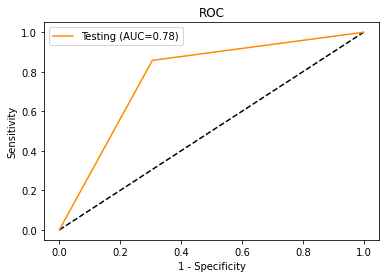

In [11]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres,X_test_hombre, y_test_hombre = training(X_hombre,y_hombre,parameters,cv)
plot_roc(model_hombres,X_test_hombre, y_test_hombre)

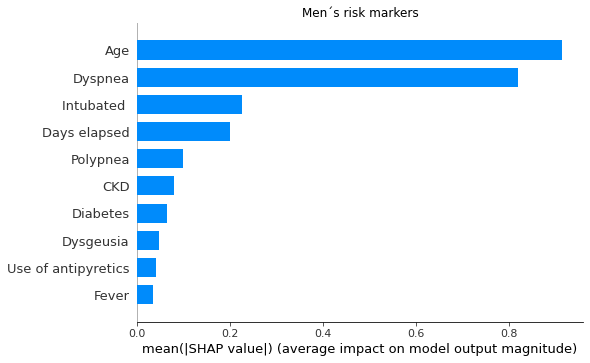

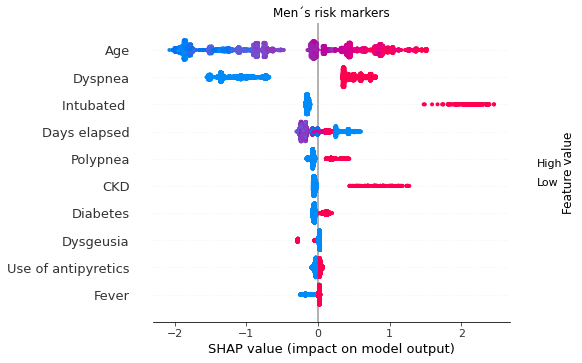

In [12]:
title = "Men´s risk markers"
plot_shap_values(model_hombres,X_hombre,feature_list_hombres,title)

# Analysis of men aged 20-29

In [13]:
data_hombres_edad_20_29 = data_hombres[(data_hombres["Age"]>=20) & ((data_hombres["Age"]<=29))] 
X_hombre_edad_20_29 = data_hombres_edad_20_29.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_20_29 = data_hombres_edad_20_29['Mortality'].astype(int)
y_hombre_edad_20_29 = y_hombre_edad_20_29.values.reshape(y_hombre_edad_20_29.shape[0],1) 
feature_list_hombres_edad_20_29 = X_hombre_edad_20_29.columns
print("X::", X_hombre_edad_20_29.shape)
print("Y::", y_hombre_edad_20_29.shape)
print(feature_list_hombres_edad_20_29)

X:: (661, 35)
Y:: (661, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[13:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

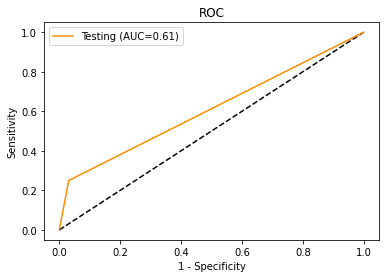

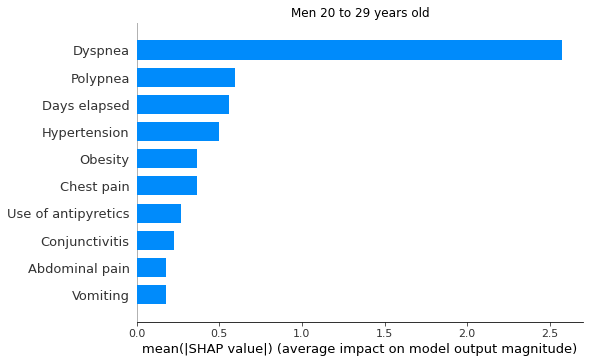

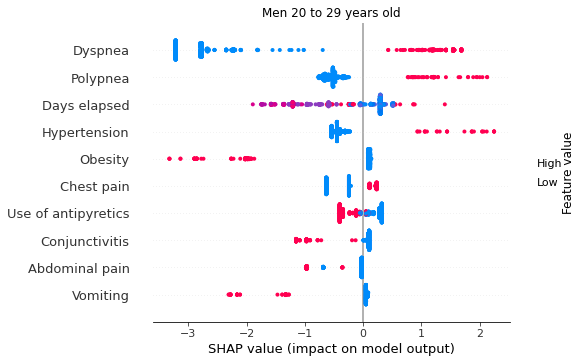

In [14]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_20_29,X_test_hombre_edad_20_29, y_test_hombre_edad_20_29 = training(X_hombre_edad_20_29,y_hombre_edad_20_29,parameters,cv)
plot_roc(model_hombres_edad_20_29,X_test_hombre_edad_20_29, y_test_hombre_edad_20_29)

title = "Men 20 to 29 years old"
plot_shap_values(model_hombres_edad_20_29,X_hombre_edad_20_29,feature_list_hombres_edad_20_29,title)

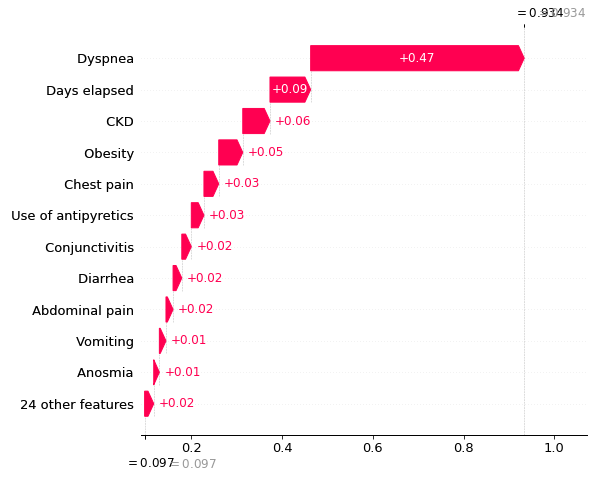

In [15]:
id = 15 
plot_waterfall(model_hombres_edad_20_29,X_hombre_edad_20_29,id,"Male patient #15 20-29",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

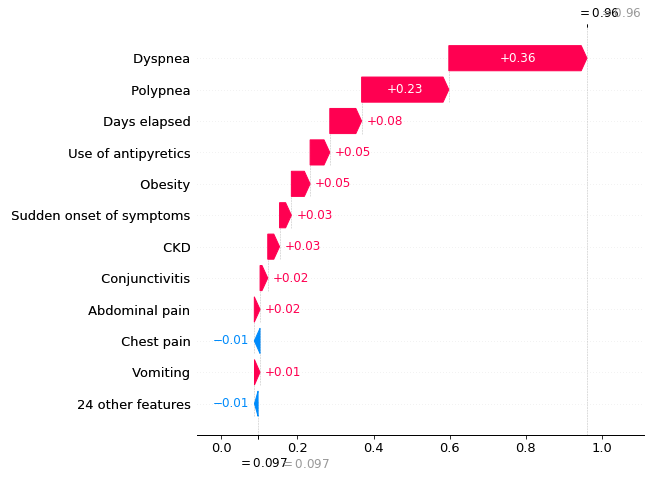

In [16]:
id = 294
plot_waterfall(model_hombres_edad_20_29,X_hombre_edad_20_29,id,"Male patient #294 20-29",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of men aged 30 to 39

In [17]:
data_hombres_edad_30_39 = data_hombres[(data_hombres["Age"]>=30) & ((data_hombres["Age"]<=39))]
X_hombre_edad_30_39 = data_hombres_edad_30_39.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_30_39 = data_hombres_edad_30_39['Mortality'].astype(int)
y_hombre_edad_30_39 = y_hombre_edad_30_39.values.reshape(y_hombre_edad_30_39.shape[0],1)
feature_list_hombres_edad_30_39 = X_hombre_edad_30_39.columns
print("X::", X_hombre_edad_30_39.shape)
print("Y::", y_hombre_edad_30_39.shape)
print(feature_list_hombres_edad_30_39)

X:: (1115, 35)
Y:: (1115, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[13:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

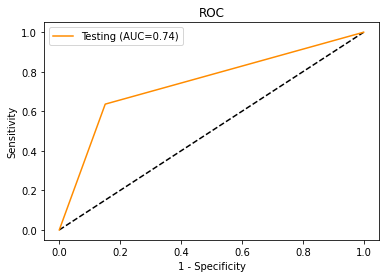

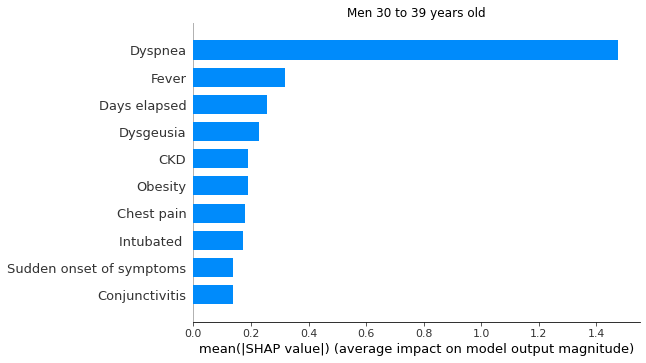

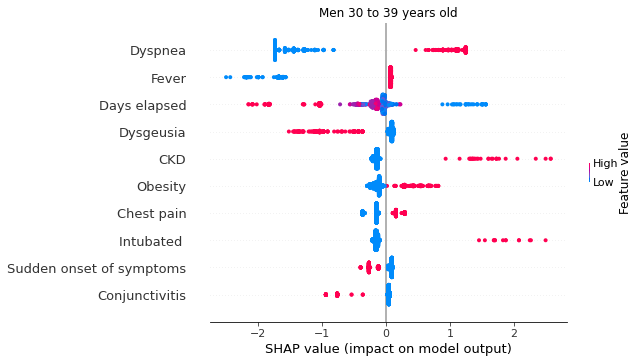

In [18]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_30_39,X_test_hombre_edad_30_39, y_test_hombre_edad_30_39 = training(X_hombre_edad_30_39,y_hombre_edad_30_39,parameters,cv)
plot_roc(model_hombres_edad_30_39,X_test_hombre_edad_30_39, y_test_hombre_edad_30_39)

title = "Men 30 to 39 years old"
plot_shap_values(model_hombres_edad_30_39,X_hombre_edad_30_39,feature_list_hombres_edad_30_39,title)

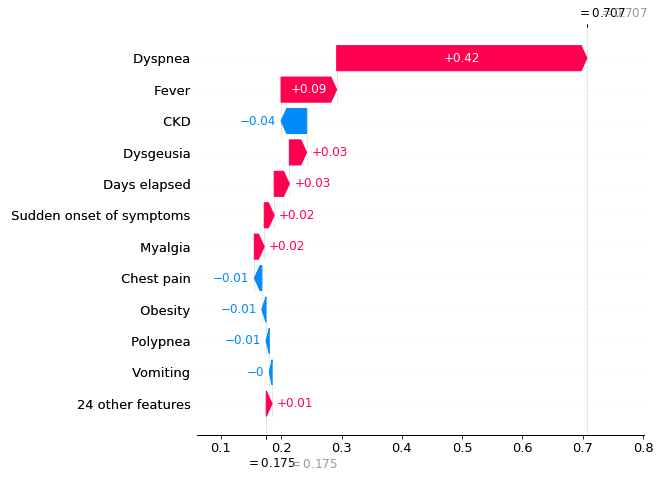

In [19]:
id = 1 
plot_waterfall(model_hombres_edad_30_39,X_test_hombre_edad_30_39,id,"Male patient #1 30-39",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of men aged 40 to 49

In [20]:
data_hombres_edad_40_49 = data_hombres[(data_hombres["Age"]>=40) & ((data_hombres["Age"]<=49))]
X_hombre_edad_40_49 = data_hombres_edad_40_49.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_40_49 = data_hombres_edad_40_49['Mortality'].astype(int)
y_hombre_edad_40_49 = y_hombre_edad_40_49.values.reshape(y_hombre_edad_40_49.shape[0],1) 
feature_list_hombres_edad_40_49 = X_hombre_edad_40_49.columns
print("X::", X_hombre_edad_40_49.shape)
print("Y::", y_hombre_edad_40_49.shape)
print(feature_list_hombres_edad_40_49)

X:: (1206, 35)
Y:: (1206, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

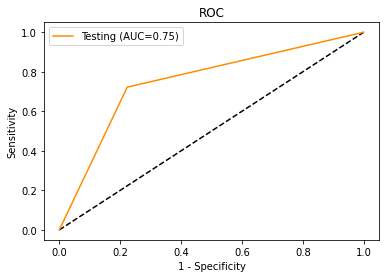

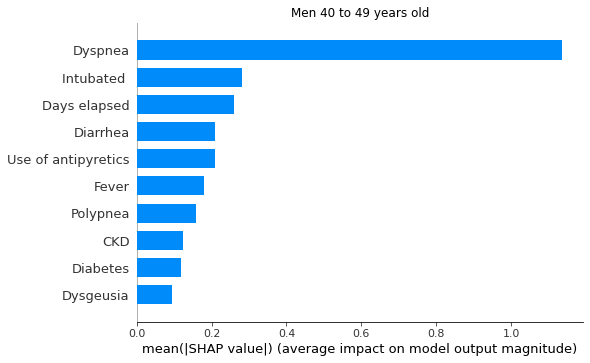

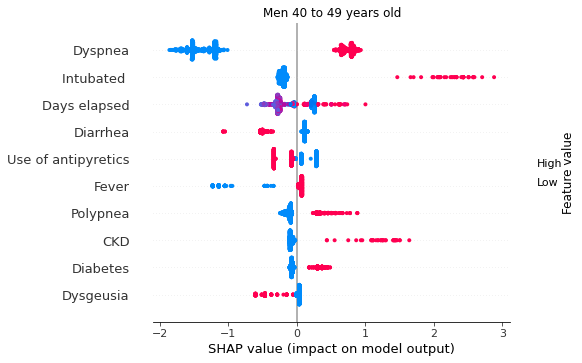

In [21]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_40_49,X_test_hombre_edad_40_49, y_test_hombre_edad_40_49 = training(X_hombre_edad_40_49,y_hombre_edad_40_49,parameters,cv)
plot_roc(model_hombres_edad_40_49,X_test_hombre_edad_40_49, y_test_hombre_edad_40_49)

title = "Men 40 to 49 years old"
plot_shap_values(model_hombres_edad_40_49,X_hombre_edad_40_49,feature_list_hombres_edad_40_49,title)

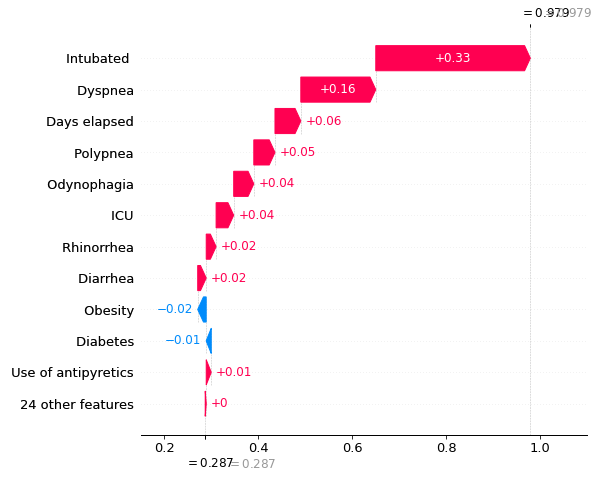

In [22]:
id = 11
plot_waterfall(model_hombres_edad_40_49,X_test_hombre_edad_40_49,id,"Male patient #11 40-49",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

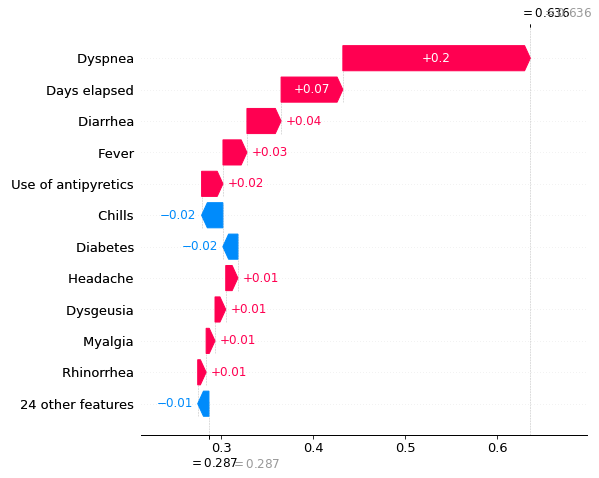

In [23]:
id = 68
plot_waterfall(model_hombres_edad_40_49,X_test_hombre_edad_40_49,id,"Male patient #68 40-49",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of men aged 50 to 59

In [24]:
data_hombres_edad_50_59 = data_hombres[(data_hombres["Age"]>=50) & ((data_hombres["Age"]<=59))]
X_hombre_edad_50_59 = data_hombres_edad_50_59.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_50_59 = data_hombres_edad_50_59['Mortality'].astype(int)
y_hombre_edad_50_59 = y_hombre_edad_50_59.values.reshape(y_hombre_edad_50_59.shape[0],1) 
feature_list_hombres_edad_50_59 = X_hombre_edad_50_59.columns
print("X::", X_hombre_edad_50_59.shape)
print("Y::", y_hombre_edad_50_59.shape)
print(feature_list_hombres_edad_50_59)

X:: (1240, 35)
Y:: (1240, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

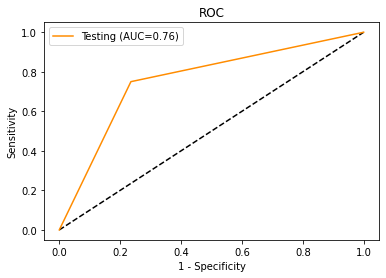

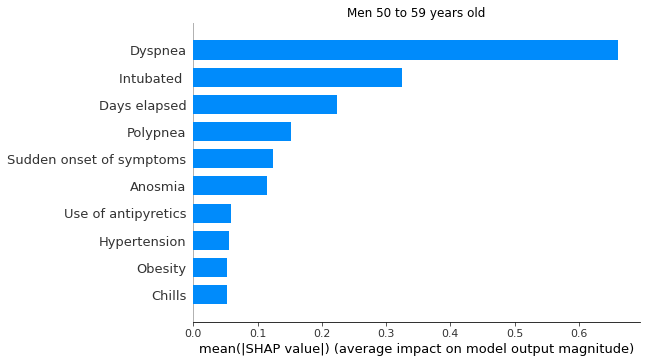

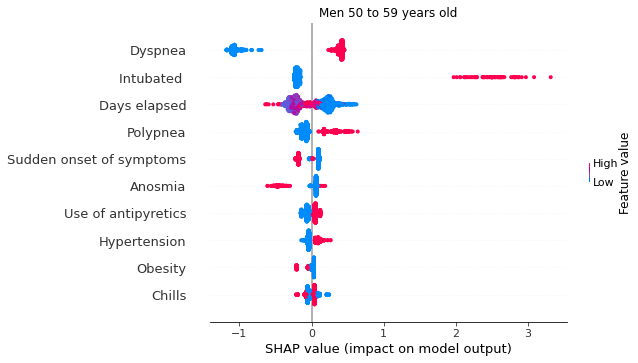

In [25]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_50_59,X_test_hombre_edad_50_59, y_test_hombre_edad_50_59 = training(X_hombre_edad_50_59,y_hombre_edad_50_59,parameters,cv)
plot_roc(model_hombres_edad_50_59,X_test_hombre_edad_50_59, y_test_hombre_edad_50_59)

title = "Men 50 to 59 years old"
plot_shap_values(model_hombres_edad_50_59,X_hombre_edad_50_59,feature_list_hombres_edad_50_59,title)

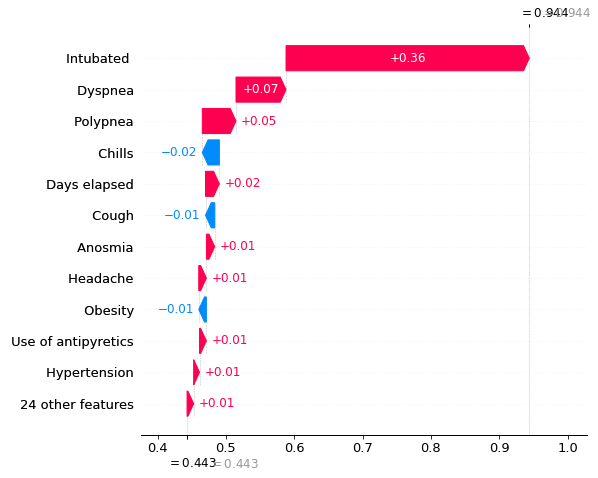

In [26]:
id = 121
plot_waterfall(model_hombres_edad_50_59,X_test_hombre_edad_50_59,id,"Male patient #121 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

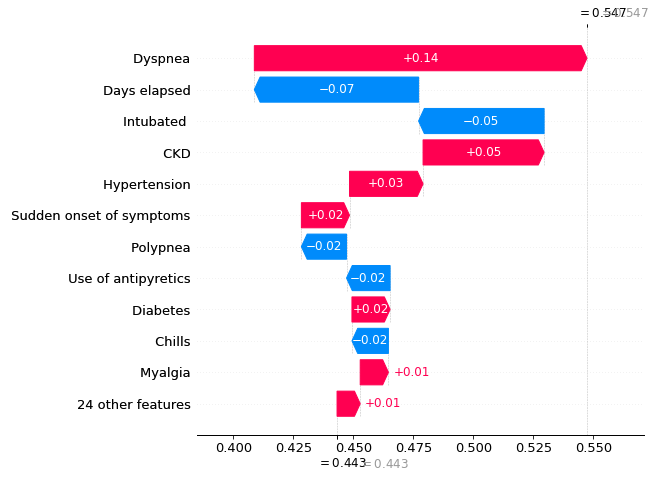

In [27]:
id = 227
plot_waterfall(model_hombres_edad_50_59,X_test_hombre_edad_50_59,id,"Male patient #227 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of men aged 60 to 69

In [28]:
data_hombres_edad_60_69 = data_hombres[(data_hombres["Age"]>=60) & ((data_hombres["Age"]<=69))] 
X_hombre_edad_60_69 = data_hombres_edad_60_69.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_60_69 = data_hombres_edad_60_69['Mortality'].astype(int)
y_hombre_edad_60_69 = y_hombre_edad_60_69.values.reshape(y_hombre_edad_60_69.shape[0],1) 
feature_list_hombres_edad_60_69 = X_hombre_edad_60_69.columns
print("X::", X_hombre_edad_60_69.shape)
print("Y::", y_hombre_edad_60_69.shape)
print(feature_list_hombres_edad_60_69)

X:: (1127, 35)
Y:: (1127, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

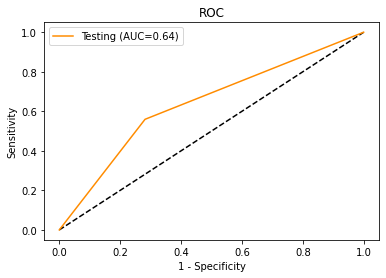

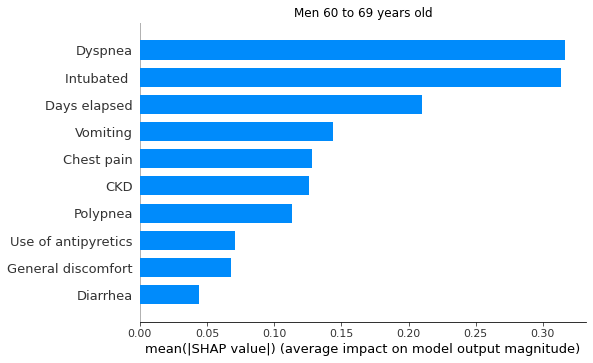

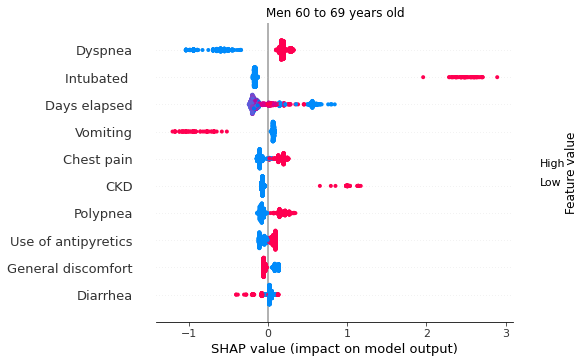

In [29]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_60_69,X_test_hombre_edad_60_69, y_test_hombre_edad_60_69 = training(X_hombre_edad_60_69,y_hombre_edad_60_69,parameters,cv)
plot_roc(model_hombres_edad_60_69,X_test_hombre_edad_60_69, y_test_hombre_edad_60_69)

title = "Men 60 to 69 years old"
plot_shap_values(model_hombres_edad_60_69,X_hombre_edad_60_69,feature_list_hombres_edad_60_69,title)

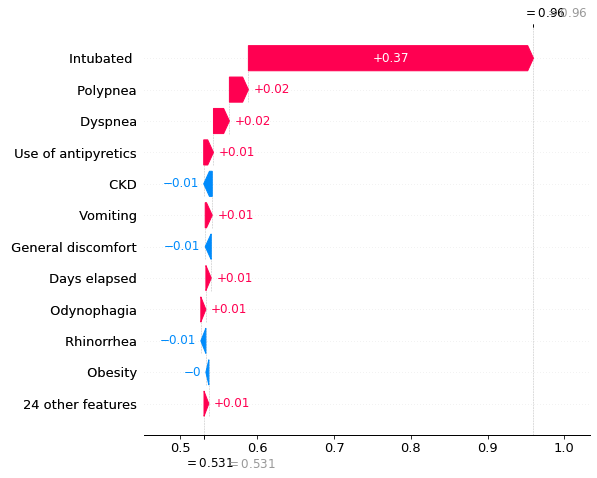

In [30]:
id = 12
plot_waterfall(model_hombres_edad_60_69,X_test_hombre_edad_60_69,id,"Male patient #12 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

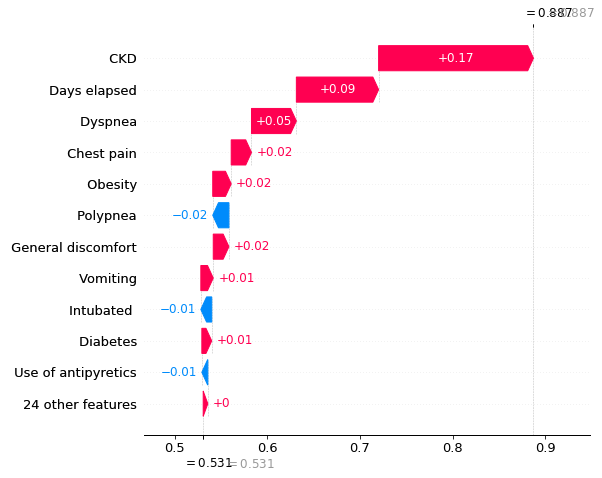

In [31]:
id = 178
plot_waterfall(model_hombres_edad_60_69,X_test_hombre_edad_60_69,id,"Male patient #178 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of men aged 70 and over


In [32]:
data_hombres_edad_70 = data_hombres[(data_hombres["Age"]>=70)]
X_hombre_edad_70 = data_hombres_edad_70.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA','Mortality','Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_70 = data_hombres_edad_70['Mortality'].astype(int)
y_hombre_edad_70 = y_hombre_edad_70.values.reshape(y_hombre_edad_70.shape[0],1)
feature_list_hombres_edad_70 = X_hombre_edad_70.columns
print("X::", X_hombre_edad_70.shape)
print("Y::", y_hombre_edad_70.shape)
print(feature_list_hombres_edad_70)

X:: (1121, 35)
Y:: (1121, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:30:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

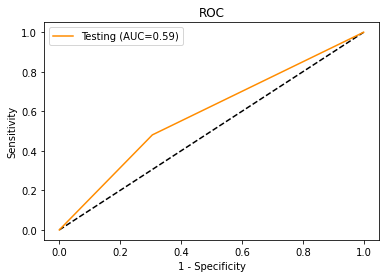

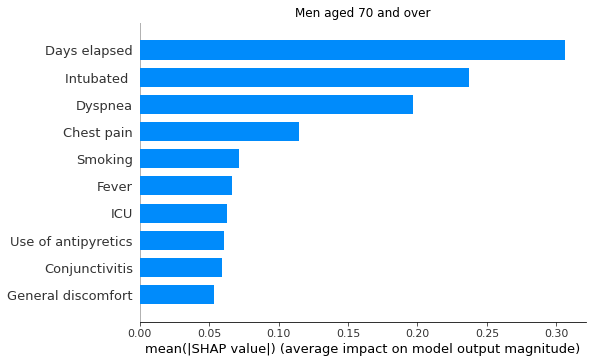

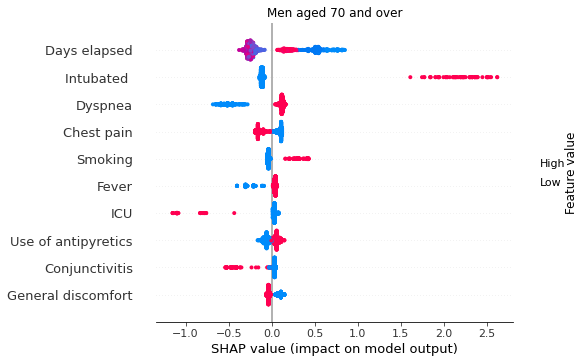

In [33]:
"""Entrenamiendo del modelo: hombres de 70 o más años de edad"""
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_70,X_test_hombre_edad_70, y_test_hombre_edad_70 = training(X_hombre_edad_70,y_hombre_edad_70,parameters,cv)
plot_roc(model_hombres_edad_70,X_test_hombre_edad_70, y_test_hombre_edad_70)

title = "Men aged 70 and over"
plot_shap_values(model_hombres_edad_70,X_hombre_edad_70,feature_list_hombres_edad_70,title)

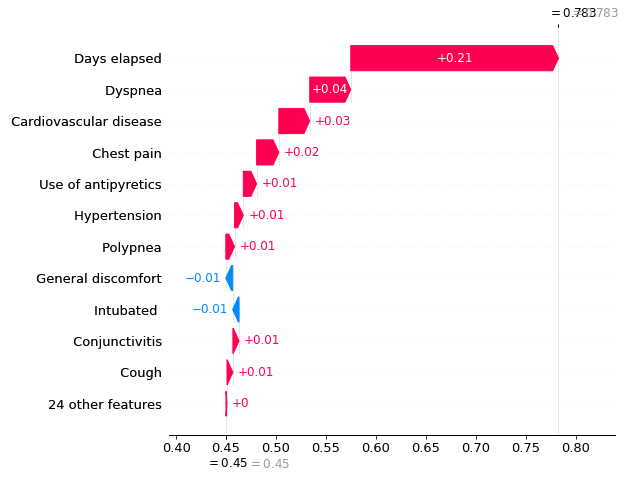

In [34]:
id = 160
plot_waterfall(model_hombres_edad_70, X_test_hombre_edad_70,id, "Male patient #160 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

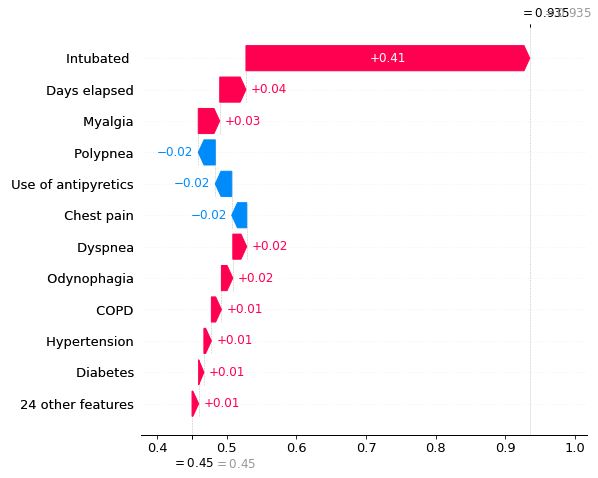

In [35]:
id = 170
plot_waterfall(model_hombres_edad_70, X_test_hombre_edad_70,id, "Male patient #170 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of women

In [36]:
data_mujer = data[(data["Sex"]==0)] 
X_mujer = data_mujer.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex',],axis=1)
y_mujer = data_mujer['Mortality'].astype(int)
y_mujer = y_mujer.values.reshape(y_mujer.shape[0],1) 
feature_list_mujer = X_mujer.columns
print("X::", X_mujer.shape)
print("Y::", y_mujer.shape)
print(feature_list_mujer)

X:: (5498, 38)
Y:: (5498, 1)
Index(['Intubated ', 'Age', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia',
       'Dyspnea', 'Irritability', 'Diarrhea', 'Chest pain', 'Chills',
       'Headache', 'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea',
       'Polypnea', 'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

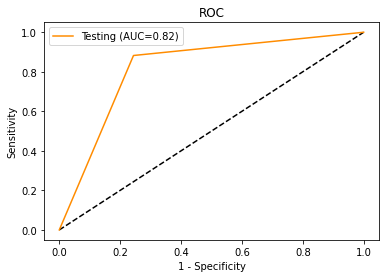

In [37]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujer,X_test_mujer, y_test_mujer = training(X_mujer,y_mujer,parameters,cv)
plot_roc(model_mujer,X_test_mujer, y_test_mujer)

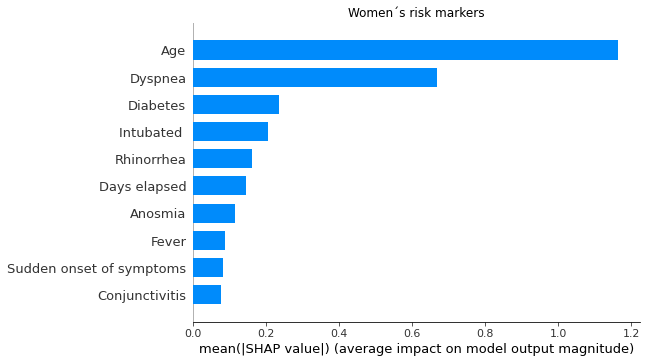

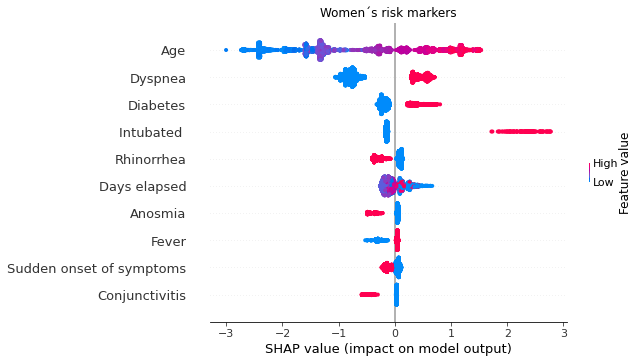

In [38]:
title = "Women´s risk markers"
plot_shap_values(model_mujer,X_mujer,feature_list_mujer,title)

# Analysis of men aged 30 to 39

In [39]:
data_mujeres_edad_30_39 = data_mujer[(data_mujer["Age"]>=30) & ((data_mujer["Age"]<=39))]
X_mujer_edad_30_39 = data_mujeres_edad_30_39.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Age','Sex',],axis=1)
y_mujer_edad_30_39 = data_mujeres_edad_30_39['Mortality'].astype(int)
y_mujer_edad_30_39 = y_mujer_edad_30_39.values.reshape(y_mujer_edad_30_39.shape[0],1)
feature_list_mujeres_edad_30_39 = X_mujer_edad_30_39.columns
print("X::", X_mujer_edad_30_39.shape)
print("Y::", y_mujer_edad_30_39.shape)
print(feature_list_mujeres_edad_30_39)

X:: (1143, 37)
Y:: (1143, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:31:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

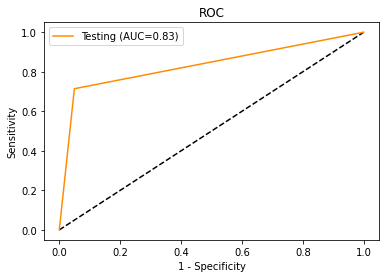

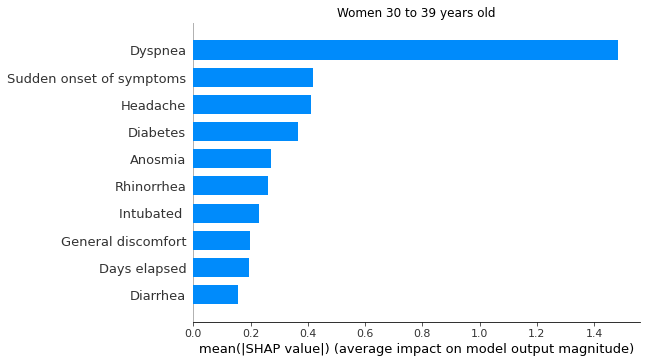

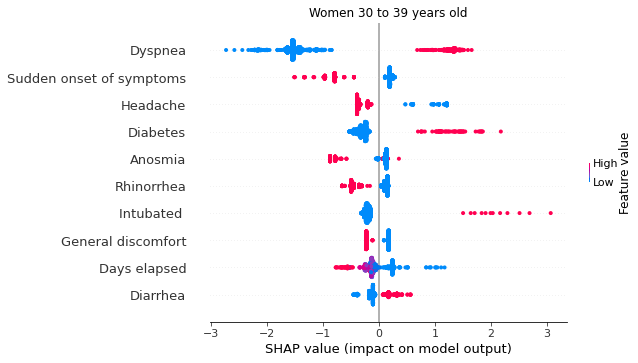

In [40]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_30_39,X_test_mujer_edad_30_39, y_test_mujer_edad_30_39 = training(X_mujer_edad_30_39,y_mujer_edad_30_39,parameters,cv)
plot_roc(model_mujeres_edad_30_39,X_test_mujer_edad_30_39, y_test_mujer_edad_30_39)

title = "Women 30 to 39 years old"
plot_shap_values(model_mujeres_edad_30_39,X_mujer_edad_30_39,feature_list_mujeres_edad_30_39,title)

# Análisis de mujeres de 40 a 49 años de edad

In [41]:
data_mujeres_edad_40_49 = data_mujer[(data_mujer["Age"]>=40) & ((data_mujer["Age"]<=49))]
X_mujer_edad_40_49 = data_mujeres_edad_40_49.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Age','Sex',],axis=1)
y_mujer_edad_40_49 = data_mujeres_edad_40_49['Mortality'].astype(int)
y_mujer_edad_40_49 = y_mujer_edad_40_49.values.reshape(y_mujer_edad_40_49.shape[0],1)
feature_list_mujeres_edad_40_49 = X_mujer_edad_40_49.columns
print("X::", X_mujer_edad_40_49.shape)
print("Y::", y_mujer_edad_40_49.shape)
print(feature_list_mujeres_edad_40_49)

X:: (1090, 37)
Y:: (1090, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:31:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

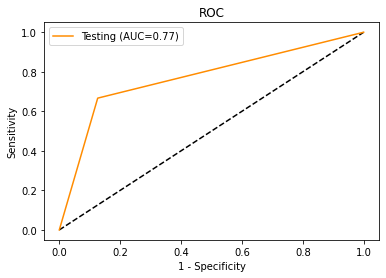

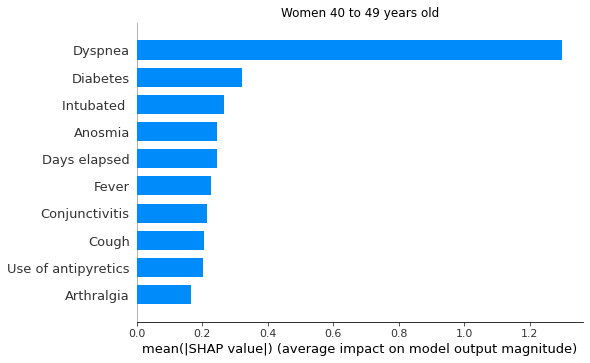

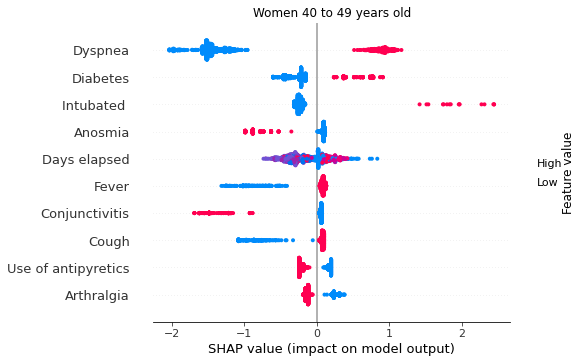

In [42]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_40_49,X_test_mujer_edad_40_49, y_test_mujer_edad_40_49 = training(X_mujer_edad_40_49,y_mujer_edad_40_49,parameters,cv)
plot_roc(model_mujeres_edad_40_49,X_test_mujer_edad_40_49, y_test_mujer_edad_40_49)

title = "Women 40 to 49 years old"
plot_shap_values(model_mujeres_edad_40_49,X_mujer_edad_40_49,feature_list_mujeres_edad_40_49,title)

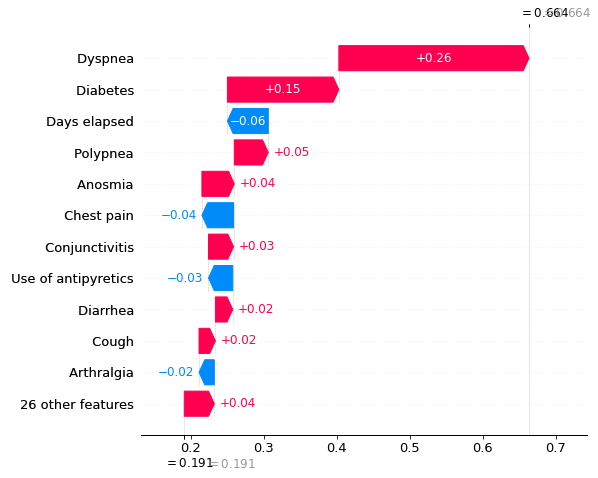

In [43]:
id = 27
plot_waterfall(model_mujeres_edad_40_49,X_test_mujer_edad_40_49,id,"Famale patient #27 40-49",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of women aged 50 to 59

In [44]:
data_mujeres_edad_50_59 = data_mujer[(data_mujer["Age"]>=50) & ((data_mujer["Age"]<=59))]
X_mujer_edad_50_59 = data_mujeres_edad_50_59.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_50_59 = data_mujeres_edad_50_59['Mortality'].astype(int)
y_mujer_edad_50_59 = y_mujer_edad_50_59.values.reshape(y_mujer_edad_50_59.shape[0],1) 
feature_list_mujeres_edad_50_59 = X_mujer_edad_50_59.columns
print("X::", X_mujer_edad_50_59.shape)
print("Y::", y_mujer_edad_50_59.shape)
print(feature_list_mujeres_edad_50_59)

X:: (994, 37)
Y:: (994, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

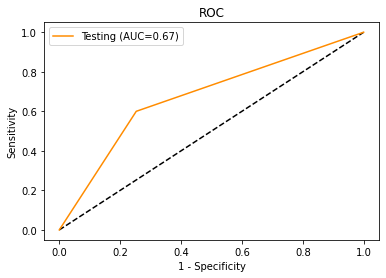

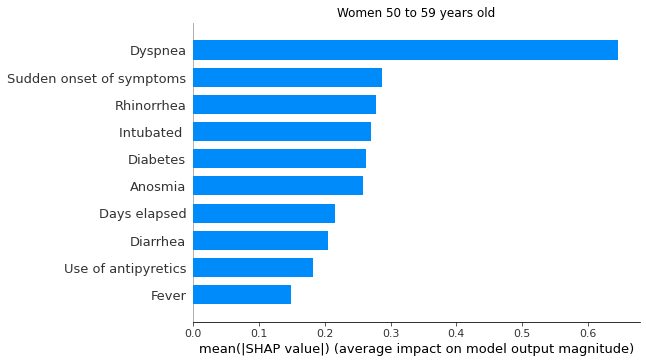

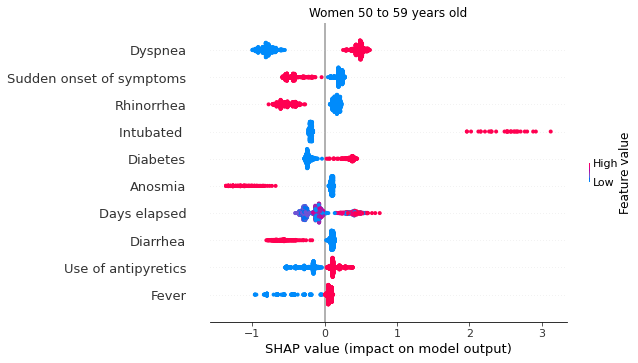

In [45]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_50_59,X_test_mujer_edad_50_59, y_test_mujer_edad_50_59 = training(X_mujer_edad_50_59,y_mujer_edad_50_59,parameters,cv)
plot_roc(model_mujeres_edad_50_59,X_test_mujer_edad_50_59, y_test_mujer_edad_50_59)

title = "Women 50 to 59 years old"
plot_shap_values(model_mujeres_edad_50_59,X_mujer_edad_50_59,feature_list_mujeres_edad_50_59,title)

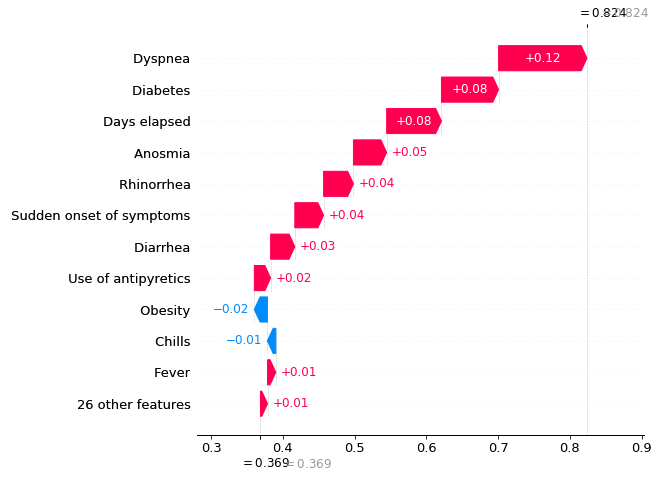

In [46]:
id = 35
plot_waterfall(model_mujeres_edad_50_59,X_test_mujer_edad_50_59,id,"Famale patient #35 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

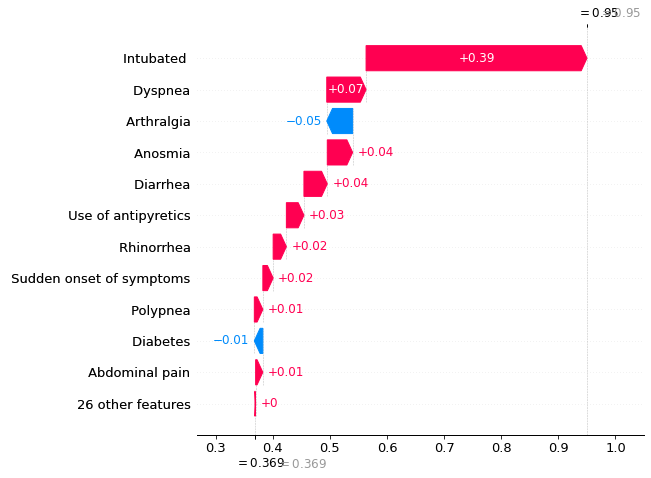

In [47]:
id = 44
plot_waterfall(model_mujeres_edad_50_59,X_test_mujer_edad_50_59,id,"Famale patient #44 50-59",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Analysis of women aged 60 to 69

In [48]:
data_mujeres_edad_60_69 = data_mujer[(data_mujer["Age"]>=60) & ((data_mujer["Age"]<=69))]
X_mujer_edad_60_69 = data_mujeres_edad_60_69.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Age','Sex',],axis=1)
y_mujer_edad_60_69 = data_mujeres_edad_60_69['Mortality'].astype(int)
y_mujer_edad_60_69 = y_mujer_edad_60_69.values.reshape(y_mujer_edad_60_69.shape[0],1) 
feature_list_mujeres_edad_60_69 = X_mujer_edad_60_69.columns
print("X::", X_mujer_edad_60_69.shape)
print("Y::", y_mujer_edad_60_69.shape)
print(feature_list_mujeres_edad_60_69)

X:: (749, 37)
Y:: (749, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

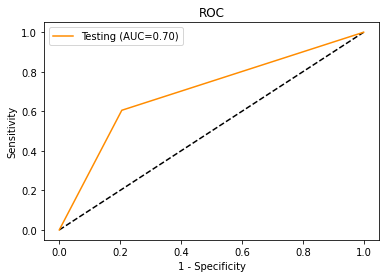

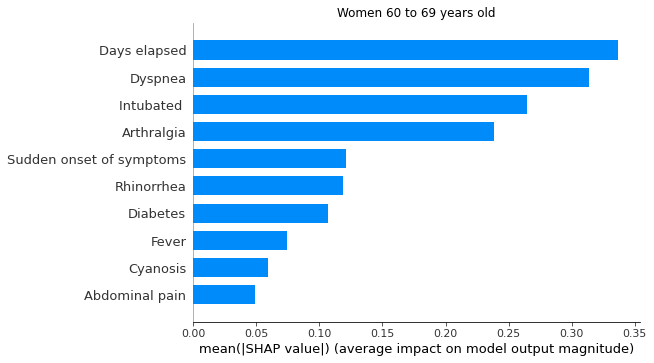

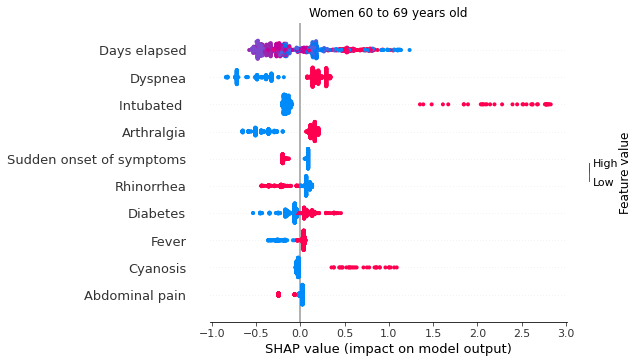

In [49]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_60_69,X_test_mujer_edad_60_69, y_test_mujer_edad_60_69 = training(X_mujer_edad_60_69,y_mujer_edad_60_69,parameters,cv)
plot_roc(model_mujeres_edad_60_69,X_test_mujer_edad_60_69, y_test_mujer_edad_60_69)

title = "Women 60 to 69 years old"
plot_shap_values(model_mujeres_edad_60_69,X_mujer_edad_60_69,feature_list_mujeres_edad_60_69,title)

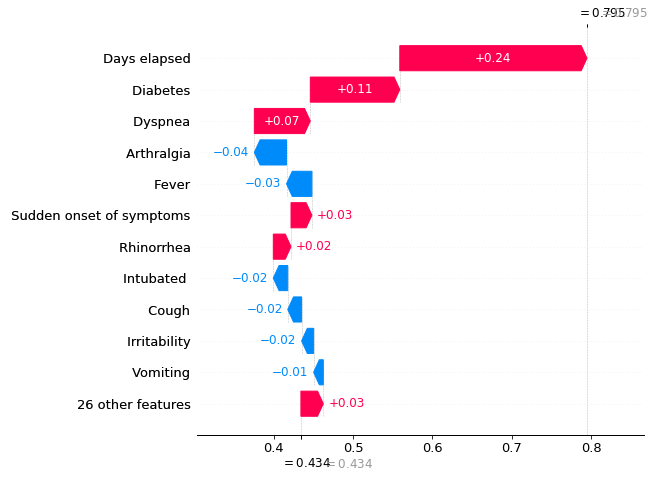

In [50]:
id = 28
plot_waterfall(model_mujeres_edad_60_69,X_test_mujer_edad_60_69,id,"Famale patient #28 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

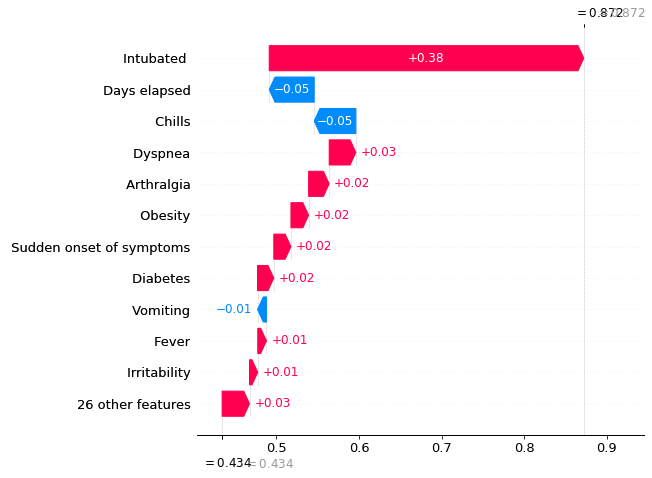

In [51]:
id = 123
plot_waterfall(model_mujeres_edad_60_69,X_test_mujer_edad_60_69,id,"Famale patient #123 60-69",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

# Análisis de mujeres de 70 o más años de edad

In [52]:
data_mujeres_edad_70 = data_mujer[(data_mujer["Age"]>=70)]
X_mujer_edad_70 = data_mujeres_edad_70.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Age','Sex',],axis=1)
y_mujer_edad_70 = data_mujeres_edad_70['Mortality'].astype(int)
y_mujer_edad_70 = y_mujer_edad_70.values.reshape(y_mujer_edad_70.shape[0],1)
feature_list_mujeres_edad_70 = X_mujer_edad_70.columns
print("X::", X_mujer_edad_70.shape)
print("Y::", y_mujer_edad_70.shape)
print(feature_list_mujeres_edad_70)

X:: (678, 37)
Y:: (678, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[13:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[13:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

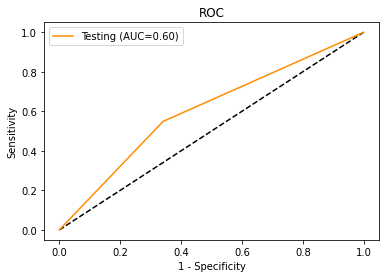

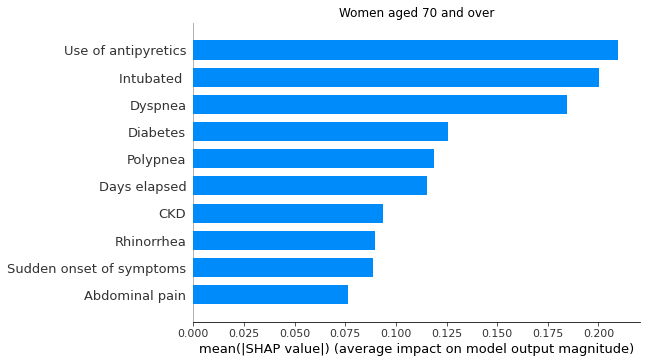

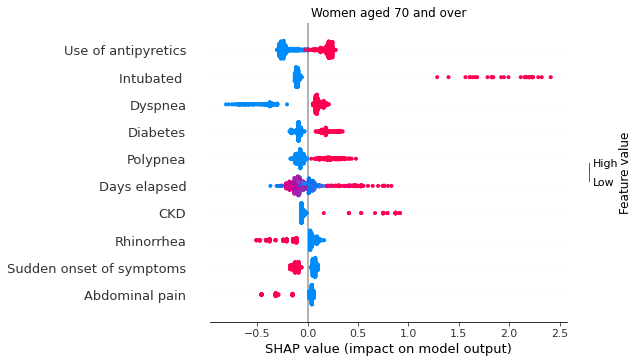

In [53]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_70,X_test_mujer_edad_70, y_test_mujer_edad_70 = training(X_mujer_edad_70,y_mujer_edad_70,parameters,cv)
plot_roc(model_mujeres_edad_70,X_test_mujer_edad_70, y_test_mujer_edad_70)

title = "Women aged 70 and over"
plot_shap_values(model_mujeres_edad_70,X_mujer_edad_70,feature_list_mujeres_edad_70,title)

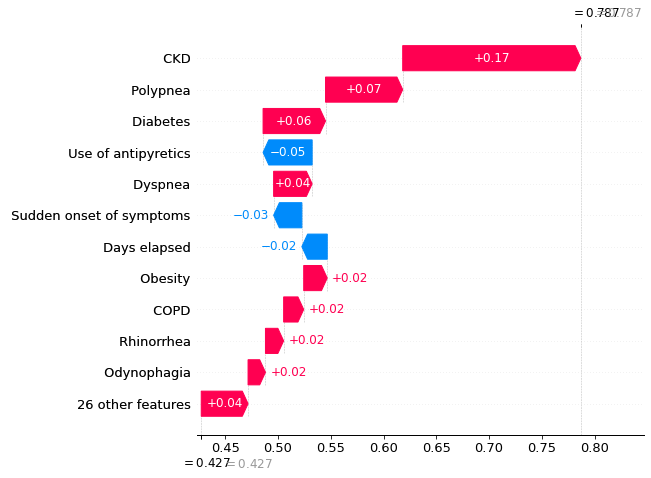

In [54]:
id = 5
plot_waterfall(model_mujeres_edad_70,X_test_mujer_edad_70,id,"Famale patient #5 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')

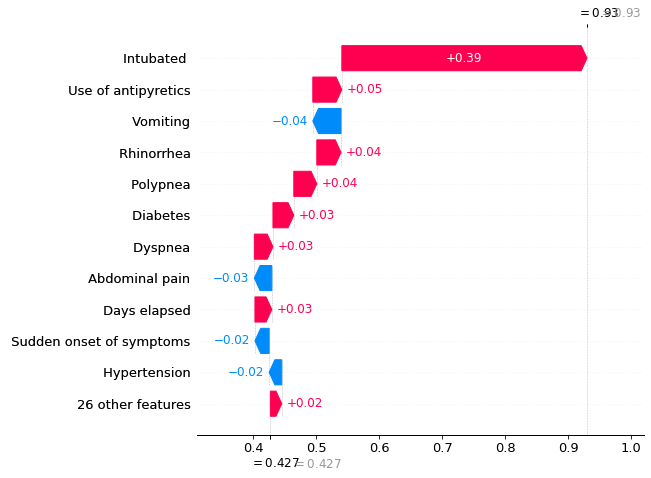

In [55]:
id = 27
plot_waterfall(model_mujeres_edad_70,X_test_mujer_edad_70,id,"Famale patient #27 70",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/waterfall')